# Evaluating ability to account for other machines

Notebook to investigate the ability to use predictions from the CNN and to feed them into a secondary model to predict other machine pull times.

In [1]:
import os
import time

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.data.config import load_config
from optpresso.data.partition import find_test_paths
from optpresso.models.serialization import load_model

from astropy import stats as asp
from astropy.utils import NumpyRNGContext

from scipy.stats import kendalltau, trim_mean, pearsonr, spearmanr

In [2]:
def convert_datetime_to_epoch_time(date):
    return (date.astype("uint64") / 1e9).astype("uint32")

def prepare_df_for_gp(frame, prediction_column="grindersetting", encoders={}, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        try:
            new_frame = new_frame.drop([col], axis=1)
        except KeyError:
            continue
    for col, encoder in encoders.items():
        if col not in new_frame:
            print("No such column:", col)
            continue
        vals = encoder.transform(np.asarray(new_frame[col]).reshape(-1, 1))
        
        new_frame[col] = [vals[i] for i in range(len(vals))] 
        
    
    y = np.asarray(new_frame[prediction_column])
    for drop_col in [prediction_column]:
        try:
            new_frame = new_frame.drop(drop_col, axis=1)
        except KeyError:
            continue
    # Sort the columns so the ordering is consistent
    cols = list(sorted(new_frame.columns.tolist()))
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    frame_array = new_frame[cols].to_numpy()
    x = np.zeros((frame_array.shape[0], np.hstack(frame_array[0]).shape[0]))
    # Surely there is a way to vectorize this?
    for i in range(frame_array.shape[0]):
        x[i] = np.hstack(frame_array[i])
    
    return x, y

def find_columns_to_drop(df, skipped_columns=None):
    if skipped_columns is None:
        skipped_columns = set()
    droppable_columns = []
    for col in df.columns:
        if col in skipped_columns:
            continue
        # Drop any column that is mostly NaNs
        if np.count_nonzero(df[col].isna()) > 0.5 * len(df[col]):
            droppable_columns.append(col)
    return droppable_columns

def cluster(clusters: int, paths: List[str]):
    timestamps = np.zeros(len(paths), dtype=np.int32)
    deltas = np.zeros(len(paths) - 1, dtype=np.int32)
    for i, path in enumerate(paths):
        pull_time = int(os.path.basename(os.path.dirname(path)))
        timestamp = os.path.basename(path).split("-")[0]
        if not timestamp.isdigit():
            raise RuntimeError(f"{path} doesn't start with timestamp!")
        timestamps[i] = int(timestamp)
        if i > 0:
            deltas[i-1] = np.abs(timestamps[i-1] - timestamps[i])
    sort = np.argsort(deltas)[::-1] # Descending order
    # Get one less indice to split, to create N chunks
    indices_to_split = sort[:clusters-1].tolist()
    idx = 0
    cluster_groups = []
    for i in range(len(paths)):
        if i == 0:
            cluster_groups.append(idx)
            continue
        if i - 1 in indices_to_split:
            idx += 1
        cluster_groups.append(idx)
        
    return np.asarray(cluster_groups, dtype=np.int32)

In [3]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Path to alternative machine data
DATA_DIR = os.path.expanduser("~/breville/")
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv&gid=1013114014"
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
config = load_config()
if config is None:
    print("Invalid config, call optpresso init")
    raise ValueError("Invalid config")
model_path = config.model
model = load_model(model_path, compile=False)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)
for key in images_by_time.keys():
    images_by_time[key].sort()

2022-02-21 09:08:27.242180: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-21 09:08:27.242212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: badisa-System-Product-Name
2022-02-21 09:08:27.242217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: badisa-System-Product-Name
2022-02-21 09:08:27.242301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.56.0
2022-02-21 09:08:27.242318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.56.0
2022-02-21 09:08:27.242323: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.56.0
2022-02-21 09:08:27.242525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to us

In [4]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
# Only take grinder settings that are numerical
df = df[pd.to_numeric(df["grindersetting"], errors="coerce").notnull()]
df["grindersetting"] = df["grindersetting"].astype(np.float64)
df[["roaster", "coffee"]] = df["coffee"].str.lower().str.split('-', 1, expand=True)
df["coffee"] = df["coffee"].astype(str).replace("None", "").str.strip()
df["roaster"] = df["roaster"].str.strip()
df["brewratio"] = df["output"] / df["coffeegrams"]
if "details" in df.columns:
    invalid_indices = df[df["details"].str.contains("no image|filter|prediction")].index
    df.drop(invalid_indices, inplace=True)

for col in find_columns_to_drop(df):
    print("Dropping", col)
    df = df.drop(col, axis=1)

date_fields = ("roastdate", "date")
for field in date_fields:
    if field in df.columns:
        df[field] = pd.to_datetime(df[field], infer_datetime_format=True, utc=True).map(convert_datetime_to_epoch_time)

encoded_cols = ("grinder", "coffee", "roaster", "machine")
encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    if len(df[col].unique()) <= 1:
        print(f"Column {col} has 1 or fewer values, skipping")
        continue
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=len(df[col].unique()))
    encoder.fit(np.asarray(df[col]).reshape(-1, 1))
    encs[col] = encoder

# Drop fields that aren't going to be encoded or are a pandas type
for field in df.columns:
    if field in encs:
        continue
    if df[field].dtype == object:
        print("Dropping", field)
        df = df.drop([field], axis=1)

fields_to_drop = ("arbitraryrating1-10",)
for field in fields_to_drop:
    if field in df.columns:
        print("Dropping", field)
        df = df.drop([field], axis=1)

### A bit of hacky code to associate CSV data with the relevant file paths

Relies on the fact that there are gaps in time between each set of images. Helped by the data is consistently
collected in this case, the training data doesn't work with the same procedure.

In [5]:
all_paths = []
for pull, paths in images_by_time.items():
    all_paths.extend(paths)
clustered = cluster(len(df), all_paths)
chunks = defaultdict(list)
for pull, paths in images_by_time.items():
    sub_df = df[df.time == pull]
    last_time = None
    groups = cluster(len(sub_df), paths)
    for group in set(groups):
        relevant_paths = [x for x in np.where(groups == group, paths, None) if x is not None]
        series_time = None
        for path in relevant_paths:
            pull_time = os.path.basename(os.path.dirname(path))
            if not pull_time.isdigit():
                raise ValueError("Invalid {}".format(relevant_paths))
            pull_time = int(pull_time)
            if series_time is None:
                series_time = pull_time
            elif series_time != pull_time:
                raise ValueError("Got multiple pull times! {}".format(relevant_paths))
        chunks[series_time].append(relevant_paths)

last_index_per_time = defaultdict(int)
predictions = []
stds = []
pulltime_idx = list(df.columns).index("time")
for row in df.values:
    pull_time = row[pulltime_idx]
    try:
        chunk_idx = last_index_per_time[pull_time]
        loader = GroundsLoader(min(256, len(chunks[pull_time][chunk_idx])), (model.input_shape[1], model.input_shape[2]), paths=chunks[pull_time][chunk_idx])
        chunk_predictions = model.predict(loader.get_batch(0, len(loader))[0]).squeeze()
        predictions.append(chunk_predictions)
        last_index_per_time[pull_time] += 1
    except IndexError:
        predictions.append(0.0)
        stds.append(0.0)
for pull, idx in last_index_per_time.items():
    if len(chunks[pull]) != idx:
        raise ValueError(f"Didn't consume all chunks: {pull} has {len(chunks[pull])}, and only used {idx}")
df["predictions"] = predictions

2022-02-21 09:08:28.349548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-21 09:08:28.455568: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 117964800 exceeds 10% of free system memory.
2022-02-21 09:08:28.490430: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 117964800 exceeds 10% of free system memory.
2022-02-21 09:08:28.789814: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167116800 exceeds 10% of free system memory.
2022-02-21 09:08:28.822991: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167116800 exceeds 10% of free system memory.
2022-02-21 09:08:29.119154: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 147456000 exceeds 10% of free system memory.


In [6]:
# Select a metric to use for the predictions
prepared_df = df.assign(
    prediction=[np.mean(predictions) for predictions in df["predictions"]],
    prediction_std=[np.std(predictions) for predictions in df["predictions"]]
)
prepared_df = prepared_df.drop("predictions", axis=1)

In [7]:
# Do an 80:20 cross validation split
train = prepared_df.sample(frac=0.7, random_state=618)
test = prepared_df.drop(train.index)

In [8]:
test

,coffeegrams,output,time,coffee,grinder,machine,grindersetting,brewratio,roaster,prediction,prediction_std
7,15.3,54.6,22,columbia,Breville,Breville Barista Express,5.0,3.568627,candlestick,13.642521,4.334969
10,15.2,54.6,22,columbia,Breville,Breville Barista Express,6.0,3.592105,candlestick,14.669835,2.119831
13,15.6,55.2,21,columbia,Breville,Breville Barista Express,7.0,3.538462,candlestick,11.956406,1.125330
15,13.3,57.3,18,columbia,Breville,Breville Barista Express,8.0,4.308271,candlestick,10.107364,2.057330
21,19.4,55.7,22,columbia,Breville,Breville Barista Express,10.0,2.871134,candlestick,18.954512,3.913096
25,18.0,41.2,23,decaf columbia,Niche Zero,Illy Francis Francis,10.0,2.288889,city of saints,37.944996,5.036312
26,16.0,42.3,25,colombia monteblanco purple caturra pineapple,Niche Zero,Illy Francis Francis,7.0,2.643750,brandywine,29.478624,2.317006
29,13.4,41.9,23,el mirador columbia,Niche Zero,Illy Francis Francis,7.0,3.126866,facsimile,28.077242,10.590651
31,16.0,35.7,29,columbia,Niche Zero,Illy Francis Francis,7.0,2.231250,candlestick,40.671227,5.993468
32,17.0,38.2,32,columbia,Niche Zero,Illy Francis Francis,7.0,2.247059,candlestick,46.948971,4.612661


## Evaluate using Gradient Boosting to make predictions

It is feasible to build a personalized Gradient Boosting (GB) model, and this is to do a basic proof of concept to see if it isn't totally worthless.

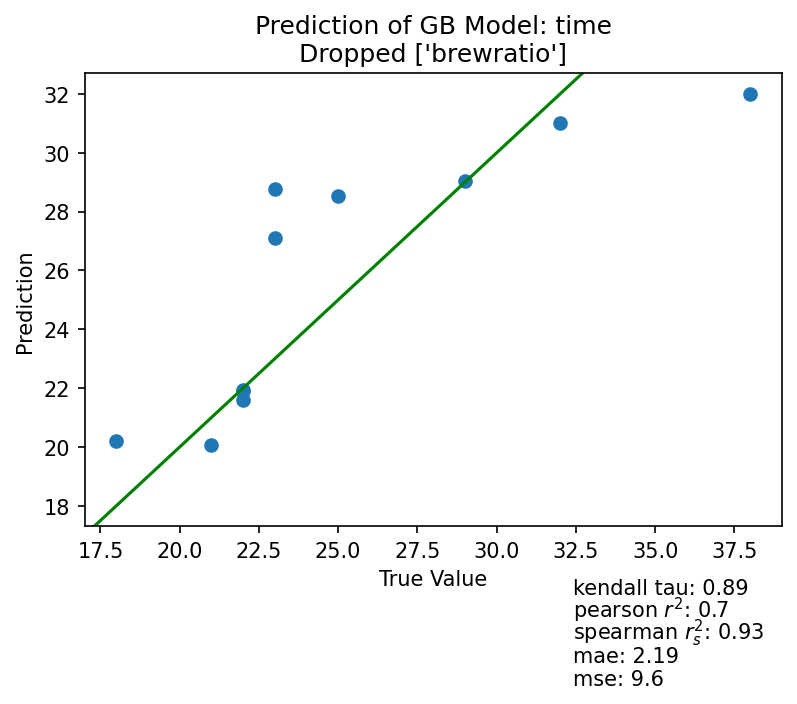

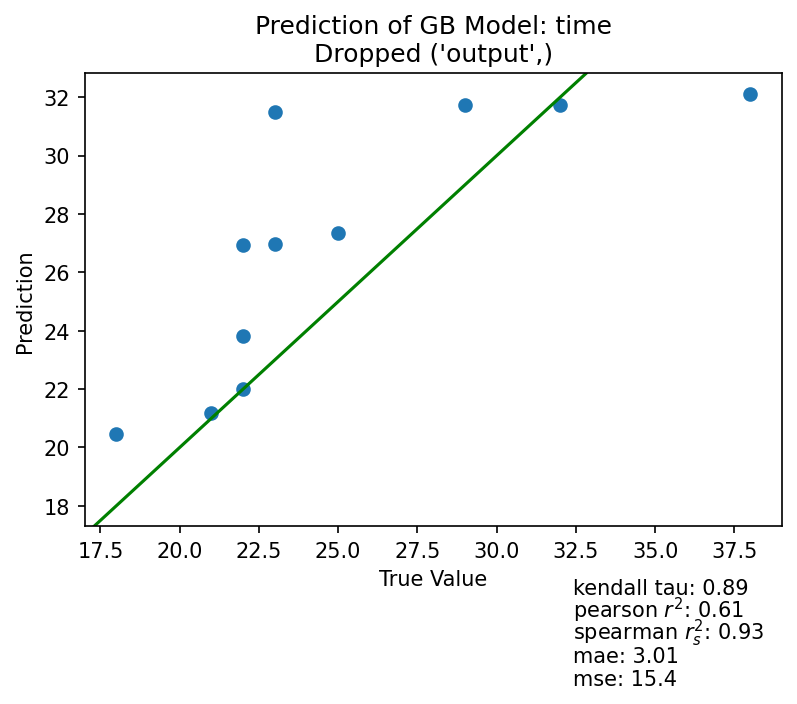

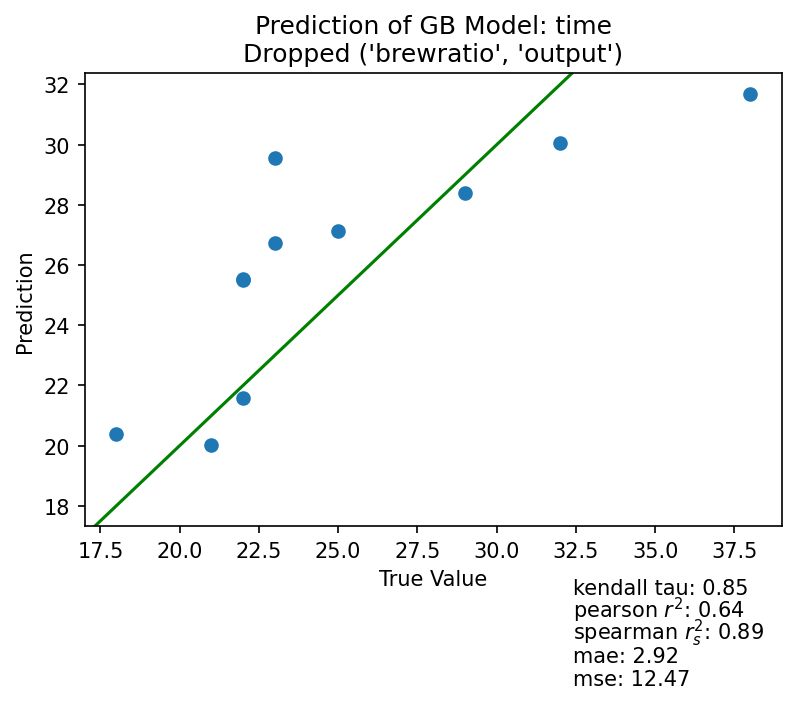

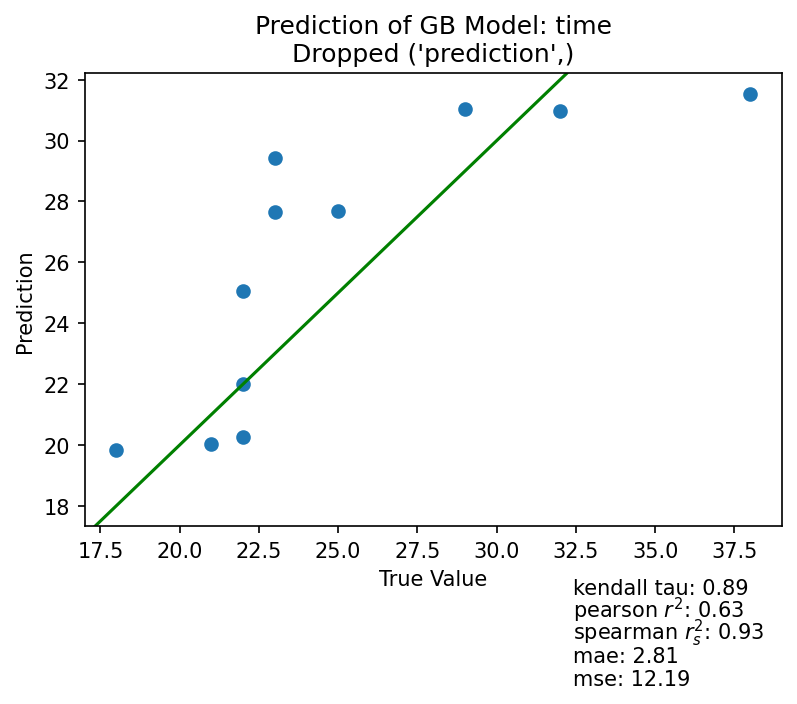

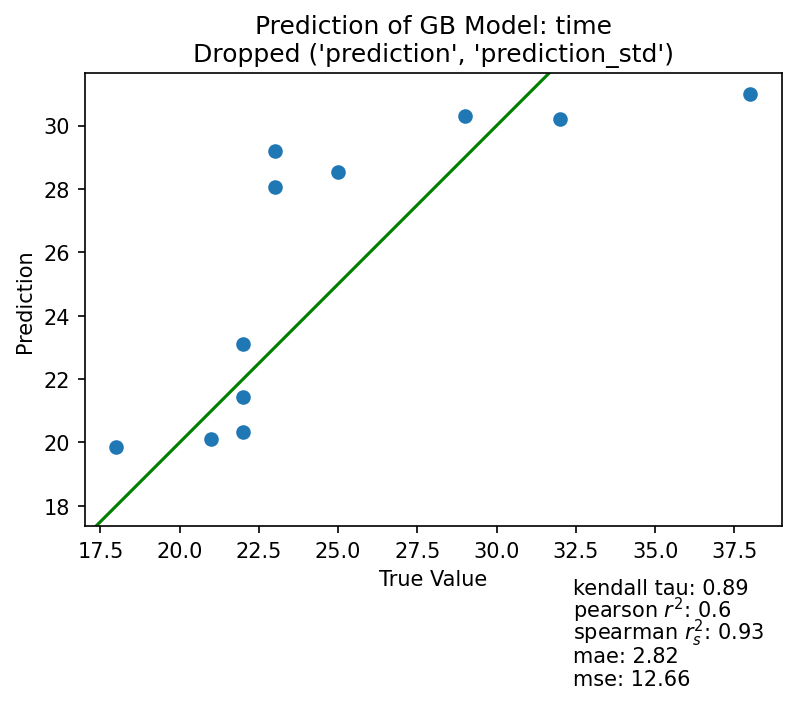

In [9]:
for pred_field in ["time"]:
    for dropped in [["brewratio"], ("output",), ("brewratio", "output"), ("prediction",), ("prediction", "prediction_std")]:
        x, y = prepare_df_for_gp(train, prediction_column=pred_field, drop_cols=dropped, encoders=encs)
        gp = GradientBoostingRegressor(n_estimators=1700)
        gp.fit(x, y)
        x_val, y_val = prepare_df_for_gp(test, prediction_column=pred_field, drop_cols=dropped, encoders=encs)
        yfit = gp.predict(x_val)
        fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111)
        ax.set_title(f"Prediction of GB Model: {pred_field}\nDropped {dropped}")
        ax.set_xlabel("True Value")
        ax.set_ylabel("Prediction")
        ax.scatter(y_val, yfit)
        ax.axline([np.min(np.concatenate([y_val, yfit]))] * 2, slope=1, color="g", label="Perfect fit")
        model_stats = {
            "kendall tau": kendalltau(y_val, yfit)[0],
            "pearson $r^2$": pearsonr(y_val, yfit)[0]**2,
            "spearman $r_{s}^2$": spearmanr(y_val, yfit)[0]**2,
            "mae": mean_absolute_error(y_val, yfit),
            "mse": mean_squared_error(y_val, yfit),
        }
        for i, (name, stat) in enumerate(model_stats.items()):
            stat = np.round(stat, 2)
            ax.annotate(
                f"{name}: {stat}",
                (0.7, -0.15 - 0.05 * i),
                xycoords="axes fraction"
            )
        plt.show()